# Additonal figures for paper

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio
from rasterio.windows import Window
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import PIL
import cv2

import glob
import os

import utils
import importlib
importlib.reload(utils)
import evaluation as eval

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"
figure_path = "/Users/conorosullivan/Google Drive/My Drive/1 UCD/0 research/JP02 - Vegetation Line/figures"

#colours
blue = "#648fff" #2017
orange = "#fe6100" #2019
red = "#dc267f" #2021
rgb_red = [220, 38, 127]
purple = "#785EF0" #overall
yellow = "#FFB000"

In [ ]:
def combine_binary_map_and_band(band,binary_map,alpha=0.6,colour=[255,0,0]):

    """ Create coloured image from binary map"""

    if band.shape[-1] != 3:

        band = (band - band.min()) / (band.max() - band.min())
        band = band*255
        band = band.astype(np.uint8)
        band_stacked = np.stack([band, band, band], axis=-1)  # shape (H, W, 3)
    else:
        band_stacked = band

    # --- 2. Blend red where GB == 1 ---
    red_overlay = np.array(colour)  # red color

    # Only apply where GB == 1
    mask = binary_map == 1
    band_stacked[mask] = (1-alpha) * band_stacked[mask] + alpha * red_overlay

    return band_stacked

# --- Load processed files ---
processed_file_path = os.path.join(data_path, "processed", "meta", "processed_files.csv")
processed_files = pd.read_csv(processed_file_path)
processed_files = processed_files[processed_files["vegetation_line"] == True]
processed_files.head(5)

ID                                           filename  \
0  20241222T113409_tramore  S2B_MSIL2A_20241222T113409_N0511_R080_T29UPT_2...   
1  20241127T113421_tramore  S2A_MSIL2A_20241127T113421_N0511_R080_T29UPT_2...   
2  20241120T114401_tramore  S2A_MSIL2A_20241120T114401_N0511_R123_T29UPT_2...   
3  20241021T114351_tramore  S2A_MSIL2A_20241021T114351_N0511_R123_T29UPT_2...   
4  20241011T114351_tramore  S2A_MSIL2A_20241011T114351_N0511_R123_T29UPT_2...   

       aoi      left        top     right     bottom        date  year  \
0  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-12-22  2024   
1  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-27  2024   
2  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-20  2024   
3  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-21  2024   
4  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-11  2024   

   vegetation_line  
0             True  
1             True  
2             True  
3             True  
4             True

### Figure: introduction

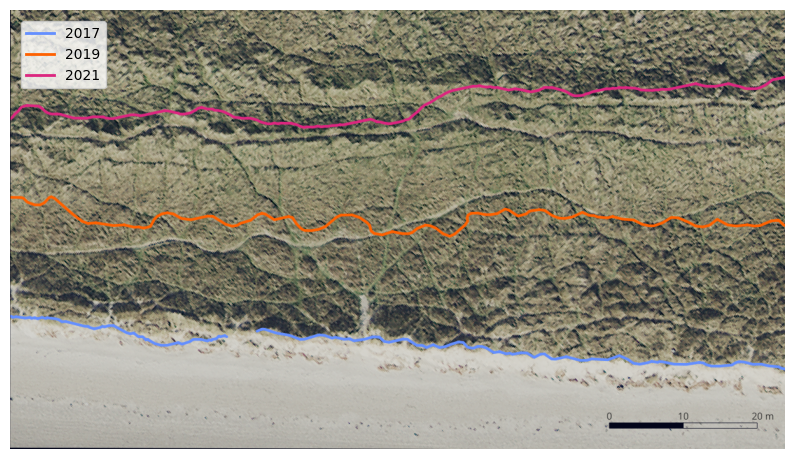

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

crop_path = figure_path+ "/rough/vl_introduction.png"
img1 = PIL.Image.open(crop_path)
ax.imshow(img1)


# create custom legend
handles = [
    plt.Line2D([0], [0], color=blue, lw=2, label='2017'),
    plt.Line2D([0], [0], color=orange, lw=2, label='2019'),
    plt.Line2D([0], [0], color=red, lw=2, label='2021')

]
ax.legend(handles=handles, loc='upper left', fontsize=10, bbox_to_anchor=(0.005, 0.99))

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

save_path = os.path.join(figure_path, "vl_introduction.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

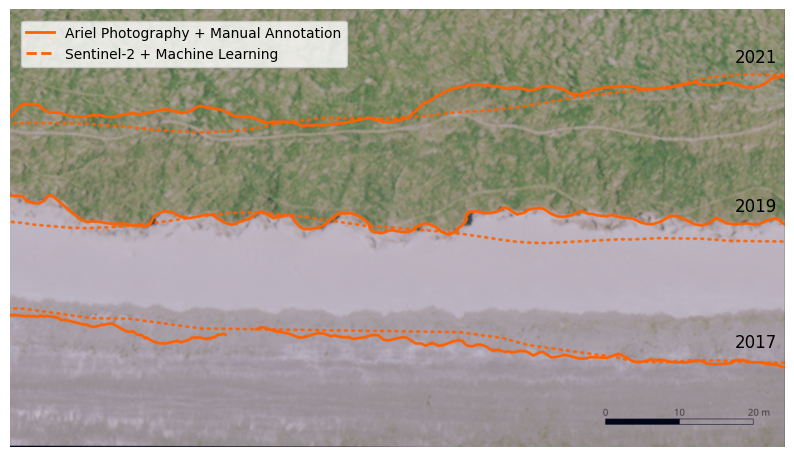

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

crop_path = figure_path+ "/rough/vl_introduction_2.png"
img1 = PIL.Image.open(crop_path)
ax.imshow(img1)


# create custom legend
handles = [

    plt.Line2D([0], [0], color=orange, lw=2, label='Ariel Photography + Manual Annotation'),
    plt.Line2D([0], [0], color=orange, lw=2,linestyle='--', label='Sentinel-2 + Machine Learning')


]
ax.legend(handles=handles, loc='upper left', fontsize=10, bbox_to_anchor=(0.005, 0.99))

# Add three dates as text on the right side
ax.text(0.99, 0.89, '2021', color='black', fontsize=12, ha='right', va='center', transform=ax.transAxes)
ax.text(0.99, 0.55, '2019', color='black', fontsize=12, ha='right', va='center', transform=ax.transAxes)
ax.text(0.99, 0.24, '2017', color='black', fontsize=12, ha='right', va='center', transform=ax.transAxes)


ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

save_path = os.path.join(figure_path, "vl_introduction_2.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

### Figure: areas of interest

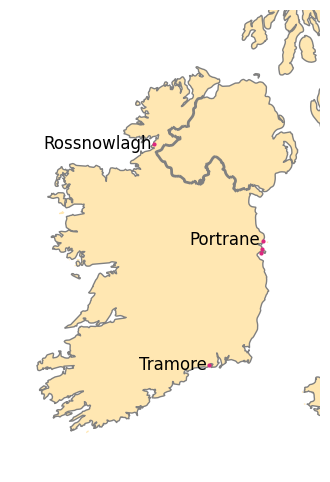

In [13]:
# --- 1. Define points (lat, lon) ---
points = [
    (53.371763767947414, -6.149601440226983),   # Bull Island
    (53.41645277618201, -6.119027060989851),      # Portmarnock
    (53.5014079187087, -6.110292945653212),      # Portrane
    (52.15837947595477, -7.143904183132022),      # Tramore
    (54.55023228884905, -8.210715488469747),    # Rossnowlagh
]


# Corresponding labels (None for points without label)
labels = [None, None, "Portrane", "Tramore", "Rossnowlagh"]

# --- 2. Create figure ---
fig = plt.figure(figsize=(4,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# --- 3. Add Ireland outline ---
ax.add_feature(cfeature.BORDERS, edgecolor='grey', linewidth=2)
ax.add_feature(cfeature.LAND, facecolor=yellow,alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=1)

# --- 4. Plot points ---
for (lat, lon), label in zip(points, labels):
    ax.plot(lon, lat, 'o', markersize=2,color=red)
    if label:
        ax.text(lon-0.05, lat-0.05, label, fontsize=12, color='black', ha='right')  # left-align text


# --- 5. Crop map around Ireland ---
ax.set_extent([-11, -5, 51, 56], crs=ccrs.PlateCarree())

# Set aspect so Ireland is taller
ax.set_aspect('auto')

# Remove axes
ax.axis('off')

# --- 6. Save image ---
map_path = os.path.join(figure_path, "rough/ireland_map.png")
plt.savefig(map_path, bbox_inches='tight', dpi=300)

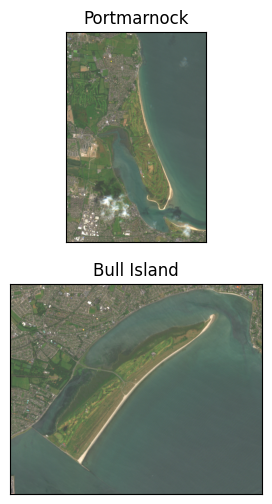

In [22]:
# Get example Sentinel-2 scene
file_name = "S2A_MSIL2A_20240623T114351_N0510_R123_T29UPV_20240623T164349"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)

rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)
rgb = utils.enhance_rgb(rgb, factor=1.5)

fig,ax = plt.subplots(2,1, figsize=(4,6))

# Portmarnock
x1,y1,x2,y2 = 8900,7450,9300,8050
crop_rgb = rgb[y1:y2,x1:x2]
ax[0].imshow(crop_rgb)
ax[0].set_title("Portmarnock")

# Bull Island
x1,y1,x2,y2 = 8700,8050,9300,8550
crop_rgb = rgb[y1:y2,x1:x2]
ax[1].imshow(crop_rgb)
ax[1].set_title("Bull Island")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

example_path = os.path.join(figure_path, "rough/location_examples.png")
plt.savefig(example_path, bbox_inches='tight', dpi=300)

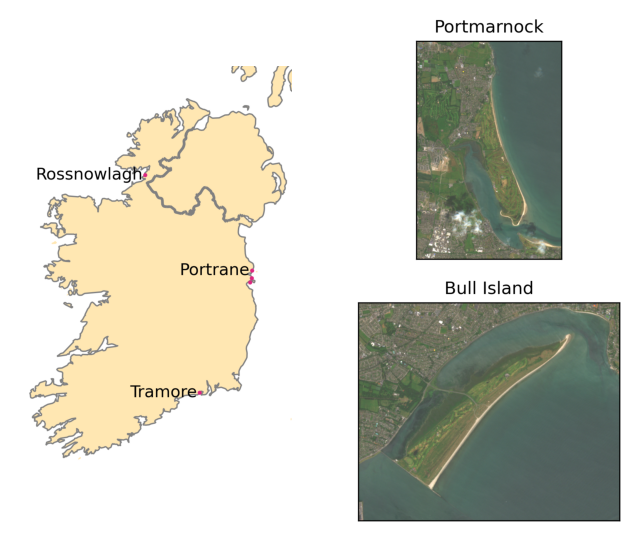

In [25]:
# Load map and examples and display them next to each other
fig, ax = plt.subplots(1,2, figsize=(8,7))

# Load and display ireland_map.png
ireland_map = plt.imread(map_path)
ireland_map = ireland_map[100: -100, 50: -80]  # Crop white space
ax[0].imshow(ireland_map)

# Load and display location_examples.png
location_examples = PIL.Image.open(example_path)
ax[1].imshow(location_examples)

for a in ax:
    a.axis('off')
    a.set_xticks([])
    a.set_yticks([])

save_path = os.path.join(figure_path, "rough/combined_location_figure.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

### Table: number of scenes per year and area of interest 

In [26]:
# count by aoi and year
count = processed_files.groupby(["aoi", "year"]).size().reset_index(name='count').sort_values(by=["aoi", "year"])

# pivot so year is columns
pivot_count = count.pivot(index="aoi", columns="year", values="count").fillna(0).astype(int)
print(len(processed_files))
pivot_count

114


year         2017  2019  2020  2022  2023  2024
aoi                                            
bull_island     8    11     0     0     8     0
portmarnock     8    10     0     0     0     0
portrane        0    11     8     9     0    10
rossnowlagh     0     0     0    16     0     0
tramore         0     0     0     0     0    15

### Figure: spectral band, guidance band and target

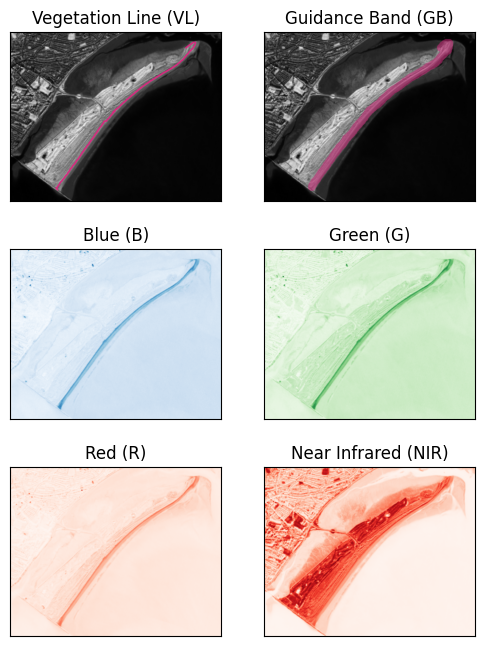

In [32]:
example_path = os.path.join(data_path, "SIVE/test_1/20171129T113419_bull_island.npy")
example = np.load(example_path)
c = 250
example = example[:,c:-c, c:-c]

fig, ax = plt.subplots(3,2, figsize=(6,8))

# Get all individual bands
B = example[2]
G = example[1]
R = example[0]
NIR = example[3]
GB = example[4]
VL = example[5]

RGB = np.dstack((R,G,B))
RGB = utils.get_rgb(RGB,contrast=0.4)
#Enhance 

band = NIR.copy()

VL = cv2.dilate(VL.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1)
VL = combine_binary_map_and_band(band,VL,alpha=1,colour=rgb_red)

ax[0,0].imshow(VL)
ax[0,0].set_title('Vegetation Line (VL)')

band = NIR.copy()
GB = combine_binary_map_and_band(band,GB,alpha=0.5,colour=rgb_red)

ax[0,1].imshow(GB)
ax[0,1].set_title('Guidance Band (GB)')

ax[1,0].imshow(B, cmap='Blues')
ax[1,0].set_title('Blue (B)')
ax[1,1].imshow(G, cmap='Greens')
ax[1,1].set_title('Green (G)')
ax[2,0].imshow(R, cmap='Reds')
ax[2,0].set_title('Red (R)')
ax[2,1].imshow(NIR, cmap='Reds')
ax[2,1].set_title('Near Infrared (NIR)')


for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

save_path = os.path.join(figure_path, "input_and_target.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

## Figure : geolocation correction

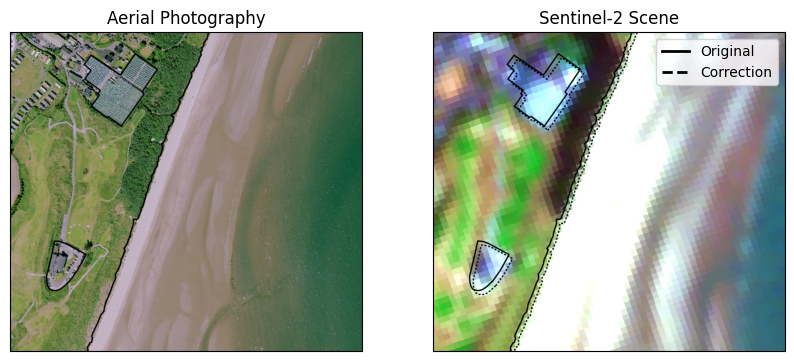

In [124]:
fig, ax = plt.subplots(1,2, figsize=(10,6))


crop_path = figure_path+ "/rough/geolocation_crop{}.png"
img1 = PIL.Image.open(crop_path.format(1))
ax[0].imshow(img1)
ax[0].set_title('Aerial Photography')

img2 = PIL.Image.open(crop_path.format(3))
ax[1].imshow(img2)
ax[1].set_title('Sentinel-2 Scene')

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# create custom legend
handles = [
    plt.Line2D([0], [0], color='black', lw=2, label='Original'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Correction')
]
ax[1].legend(handles=handles, loc='upper right', fontsize=10)

save_path = os.path.join(figure_path, "geolocation_correction.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)


## Figure: cropping 

In [33]:
veg_lines_path = os.path.join(data_path, "processed/vegetation_lines/vegetation_lines_annotations.shp")
veg_lines = gpd.read_file(veg_lines_path)
veg_lines.head()

def get_points(line,m=100):
    """
    Convert a shapely geometry to a list of points
    """
   
    length = line.geometry.length

    # Get points every m meters along the line
    num_points = int(length / m)
    points = [line.geometry.interpolate(distance, normalized=False) 
            for distance in np.linspace(0, length, num_points)]
    
    # Include last point if not already included
    if points[-1] != line.geometry.coords[-1]:
        points.append(line.geometry.interpolate(length, normalized=False))
    
    # make sure start point is included
    first_point = line.geometry.coords[0]
    assert first_point == tuple(points[0].coords[0]), "First point does not match"

    # make sure end point is included
    last_point = line.geometry.coords[-1]
    assert last_point == tuple(points[-1].coords[0]), "Last point does not match"
    
    return points

ID = "20171227T114501_bull_island"
example_raster_path = os.path.join(data_path, f"processed/aoi_stacked/bull_island/2017/{ID}.tif")

example_raster = rasterio.open(example_raster_path)
print(ID)

#crop raster 
veg_line = veg_lines[veg_lines['ID'] == ID].sample(n=1).iloc[0]
print(veg_line.geometry.length)

points = get_points(veg_line,m=100)
print(len(points))
print(points[0])

20171227T114501_bull_island
5406.936779018211
55
POINT (688629.4180177618 5915255.479428639)


(144, 144, 3)


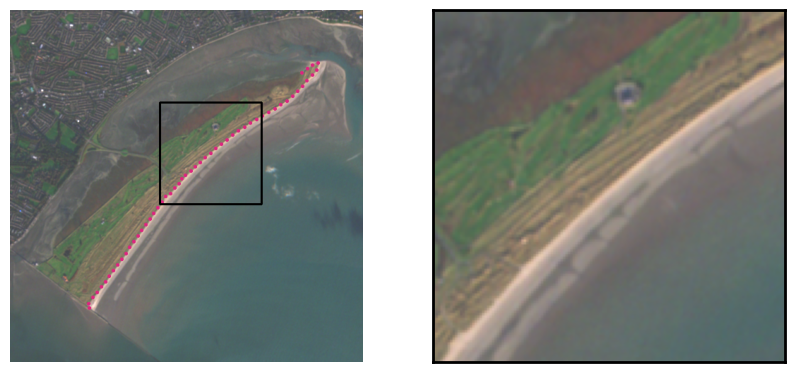

In [37]:
# Create RGB image from raster
rgb = example_raster.read()
rgb = utils.get_rgb(rgb,r=0,b=2 ,contrast=0.4)
rgb = utils.enhance_rgb(rgb, factor=1.5)
point_rgb = rgb.copy()

# Add blue points to rgb image
for point in points:
    utmx, utmy = point.x, point.y
    y, x = example_raster.index(utmx, utmy)
    point_rgb  = cv2.circle(point_rgb , (x, y), 1, rgb_red,2)


# add a square of 144 by 144 pixels center on one of the points
square_size = 144
point = points[30]
utmx, utmy = point.x, point.y
y, x = example_raster.index(utmx, utmy)

# draw square on point_rgb
point_rgb = cv2.rectangle(point_rgb, (x - square_size // 2, y - square_size // 2), (x + square_size // 2, y + square_size // 2), (0, 0, 0), 2)

# remove buffer
crop = 200
point_rgb = point_rgb[crop:-crop, crop+50:-crop-50]

# Plo
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(point_rgb)

# Crop the same area from the original image
rgb_crop = rgb[y - square_size // 2:y + square_size // 2, x - square_size // 2:x + square_size // 2]
ax[1].imshow(rgb_crop)
print(rgb_crop.shape)

ax[0].axis('off')
ax[1].set_xticks([])
ax[1].set_yticks([])
#make axis thicker
ax[1].spines['top'].set_linewidth(2)
ax[1].spines['right'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)

save_path = os.path.join(figure_path, "rough/cropping_points.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

## Figure: augmentations

In [38]:
def random_crop(raster, point, seed=0,crop_size=144, augmentation=True):

    utmx = point.x
    utmy = point.y

    y, x = raster.index(utmx, utmy)

    #set seed
    np.random.seed(seed)


# Get cropped window centered around the point
    window_x = x - crop_size // 2 
    window_y = y - crop_size // 2

    # Offset the window by a random amount within the crop size
    if augmentation:
        window_x += np.random.randint(-crop_size // 2, crop_size // 2)
        window_y += np.random.randint(-crop_size // 2, crop_size // 2)

    # Define the window for cropping
    window = Window(window_x, window_y, crop_size, crop_size)
    
    # Read 6-band image crop
    instance = raster.read(window=window)

    if augmentation:
        # Randomly flip the image and mask crops
        if np.random.rand() > 0.5:
            instance = np.flip(instance, axis=1) #axis 0 is bands, axis 1 is y, axis 2 is x

        if np.random.rand() > 0.5:
            instance = np.flip(instance, axis=2)
    
        # Randomly rotate the image and mask crops
        angle = np.random.choice([0, 90, 180, 270])
        instance = np.rot90(instance, k=angle//90, axes=(1, 2))

        guidance = instance[-2]

        # random errosion and dilation
        k= np.random.choice([3,5])
        i = np.random.randint(1, 3)
        kernel = np.ones((k, k), np.uint8)
        
        if np.random.rand() > 0.5:
            guidance = cv2.erode(guidance.astype(np.uint8), kernel, iterations=i)
        if np.random.rand() > 0.5:
            guidance = cv2.dilate(guidance.astype(np.uint8), kernel, iterations=i)
        instance[-2] = guidance    

    return instance


55
POINT (688629.4180177618 5915255.479428639)


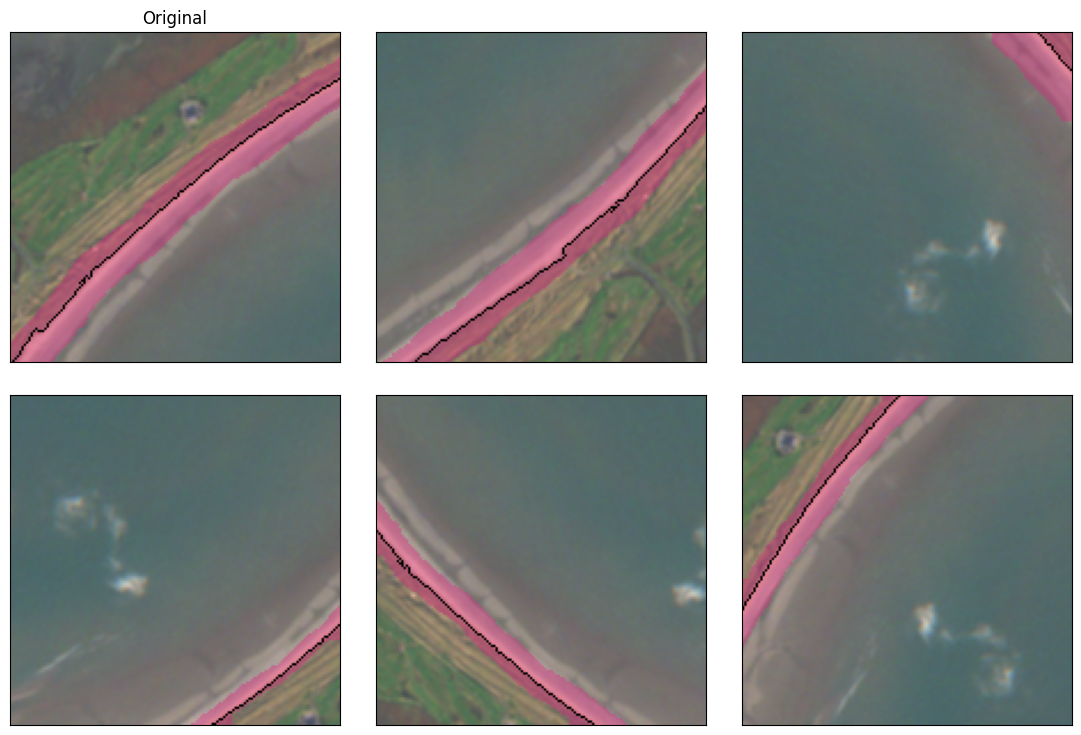

In [47]:
ID = "20171227T114501_bull_island"
example_raster_path = os.path.join(data_path, f"processed/aoi_stacked/bull_island/2017/{ID}.tif")

example_raster = rasterio.open(example_raster_path)

veg_line = veg_lines[veg_lines['ID'] == ID].sample(n=1).iloc[0]

points = get_points(veg_line,m=100)
print(len(points))
print(points[0])

point = points[30]

def get_overlay(instance):
    overlay = instance.copy()
    overlay = utils.get_rgb(overlay,r=0,b=2 ,contrast=0.4)
    overlay = utils.enhance_rgb(overlay, factor=1.5)

    overlay = combine_binary_map_and_band(overlay, instance[-2],alpha=0.4,colour=rgb_red)
    overlay = combine_binary_map_and_band(overlay, instance[-1],alpha=1,colour=[0,0,0])

    return overlay

fig, ax = plt.subplots(2, 3, figsize=(15, 9))

original = random_crop(example_raster, point, crop_size=144, augmentation=False)
original = get_overlay(original)

ax_flat = ax.ravel()

ax_flat[0].imshow(original)
ax_flat[0].set_title('Original')
ax_flat[0].set_xticks([])
ax_flat[0].set_yticks([])

seeds = [1,15,6,19,24]

for i in range(1, 6):
    example_raster = rasterio.open(example_raster_path)
    augment = random_crop(example_raster, point, seed=seeds[i-1], crop_size=144, augmentation=True)
    augment = get_overlay(augment)
    ax_flat[i].imshow(augment)
    ax_flat[i].set_xticks([])
    ax_flat[i].set_yticks([])


#reduce space between subplots
plt.subplots_adjust(wspace=-0.15, hspace=0.1)

save_path = os.path.join(figure_path, "data_augmentation.png")
fig.savefig(save_path, bbox_inches='tight', dpi=300)

## Figure: edge map combination

In [48]:
# Load the model
best_model_name= "SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth"
model_path = f'../models/SIVE_04JUN2025/{best_model_name}'
model, meta_data = utils.get_model(model_path)

# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()
points_dict.keys()

dict_keys(['20240623T114351_tramore', '20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh', '20240211T113311_portrane', '20220323T113321_portrane', '20201002T114401_portrane', '20190707T113321_portrane', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20230904T113321_bull_island', '20230604T114349_bull_island', '20230530T114351_bull_island', '20230420T114351_bull_island', '20190920T113319_bull_island', '20190826T113321_bull_island', '20190707T113321_bull_island', '20190627T113321_bull_island', '20190501T114351_bull_island', '20190411T114

In [ ]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

# Select example 
i = 7
path = test_paths[i]

ID = os.path.basename(path).split('.')[0]
points = points_dict[ID]

image = np.load(path)
crop_paths, start_points = utils.get_iterative_crops(image, points)
target_crops, pred_crops = eval.get_preds(model,meta_data["guidance"], crop_paths, batch_size=1)

In [57]:
points

{1.0: [(365, 626),
  (390, 580),
  (424, 533),
  (457, 486),
  (492, 444),
  (533, 405),
  (579, 369),
  (628, 338),
  (671, 299),
  (663, 290),
  (663, 290)]}

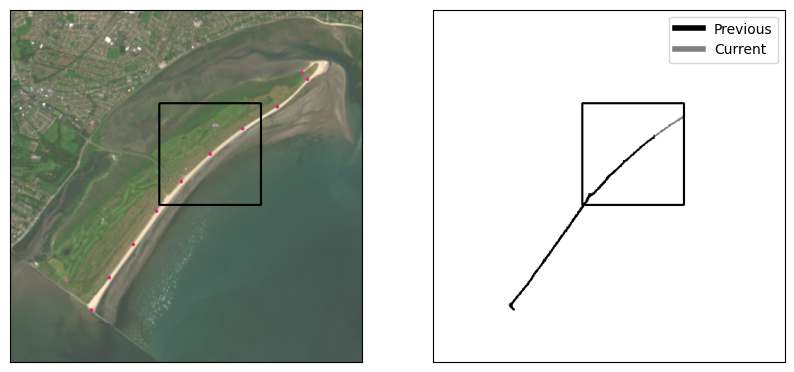

In [ ]:
rgb = image.transpose(1, 2, 0)
rgb = utils.get_rgb(rgb,r=0,b=2,contrast=0.4)


rgb = utils.enhance_rgb(rgb, factor=1.5)
point_rgb = rgb.copy()

# Add blue points to rgb image
for point in points[1]:
    x,y = point[0], point[1]
    point_rgb  = cv2.circle(point_rgb , (x, y), 1, rgb_red,2)

# add a square of 144 by 144 pixels center on one of the points
square_size = 144
n = 5 # point index
point = points[1][n]

x,y = point[0], point[1]

point_rgb = cv2.rectangle(point_rgb, (x - square_size // 2, y - square_size // 2), (x + square_size // 2, y + square_size // 2), (0, 0, 0), 2)

# remove buffer
crop = 200
point_rgb = point_rgb[crop:-crop, crop+50:-crop-50]

combined_pred = utils.combine_crops(pred_crops[:n], start_points[:n], image)
combined_pred[y-square_size//2:y+square_size//2, x-square_size//2:x+square_size//2] += pred_crops[n]/2
combined_pred = np.clip(combined_pred, 0, 1)

combined_pred = cv2.rectangle(combined_pred, (x - square_size // 2, y - square_size // 2), (x + square_size // 2, y + square_size // 2), (1, 1, 1), 2)
combined_pred = combined_pred[crop:-crop, crop+50:-crop-50]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(point_rgb)
ax[1].imshow(1-combined_pred, cmap='gray')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# custom legend with black and grey labels outside the plot on the right
handles = [plt.Line2D([0], [0], color='black', lw=4),
           plt.Line2D([0], [0], color='gray', lw=4)]
ax[1].legend(handles, ['Previous', 'Current'], loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

save_path = os.path.join(figure_path, "combined_prediction.png")

plt.savefig(save_path, bbox_inches='tight', dpi=300)

## Figure: interpolation

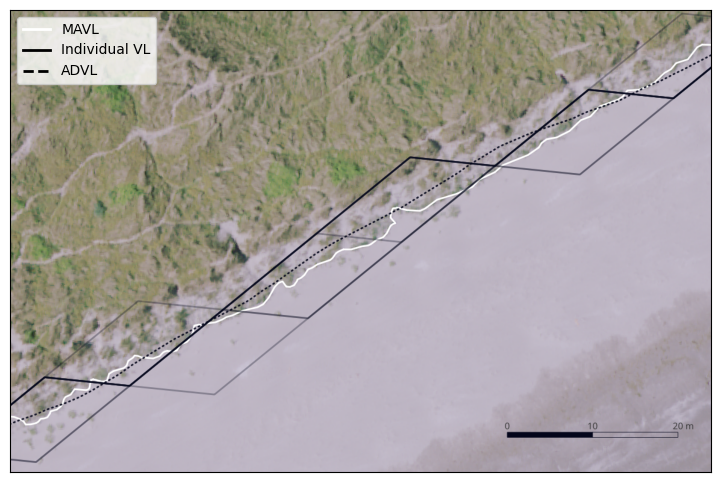

In [79]:
fig, ax = plt.subplots(1,1, figsize=(10,6))


crop_path = figure_path+ "/rough/interpolation.png"
img1 = PIL.Image.open(crop_path)
ax.imshow(img1)


# create custom legend
handles = [
    plt.Line2D([0], [0], color='white', lw=2, label='MAVL'),
    plt.Line2D([0], [0], color='black', lw=2, label='Individual VL'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='ADVL')

]
ax.legend(handles=handles, loc='upper left', fontsize=10)

ax.set_xticks([])
ax.set_yticks([])

save_path = os.path.join(figure_path, "interpolation.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

### Figure: ADVL Bull Island 

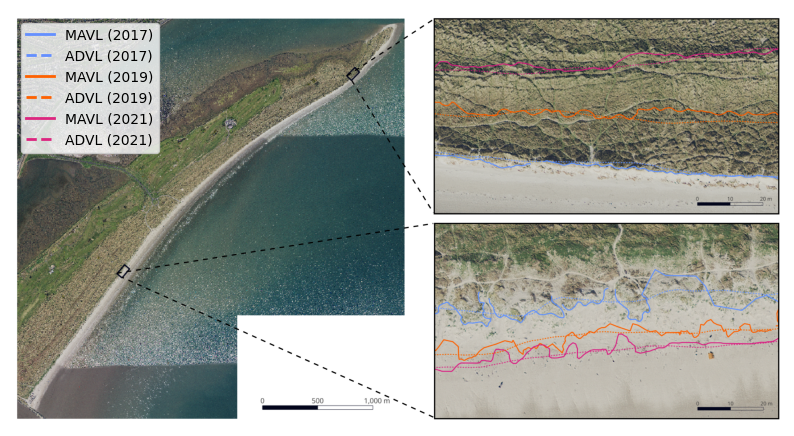

In [76]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

crop_path = figure_path+ "/rough/advl_bull_island.png"
img1 = PIL.Image.open(crop_path)
ax.imshow(img1)


# create custom legend
handles = [
    plt.Line2D([0], [0], color=blue, lw=2, label='MAVL (2017)'),
    plt.Line2D([0], [0], color=blue, lw=2, linestyle='--', label='ADVL (2017)'),
    plt.Line2D([0], [0], color=orange, lw=2, label='MAVL (2019)'),
    plt.Line2D([0], [0], color=orange, lw=2, linestyle='--', label='ADVL (2019)'),
    plt.Line2D([0], [0], color=red, lw=2, label='MAVL (2021)'),
    plt.Line2D([0], [0], color=red, lw=2, linestyle='--', label='ADVL (2021)')

]
# shift legend down a bit
ax.legend(handles=handles, loc='upper left', fontsize=10, bbox_to_anchor=(0.005, 0.985))

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

save_path = os.path.join(figure_path, "advl_bull_island.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

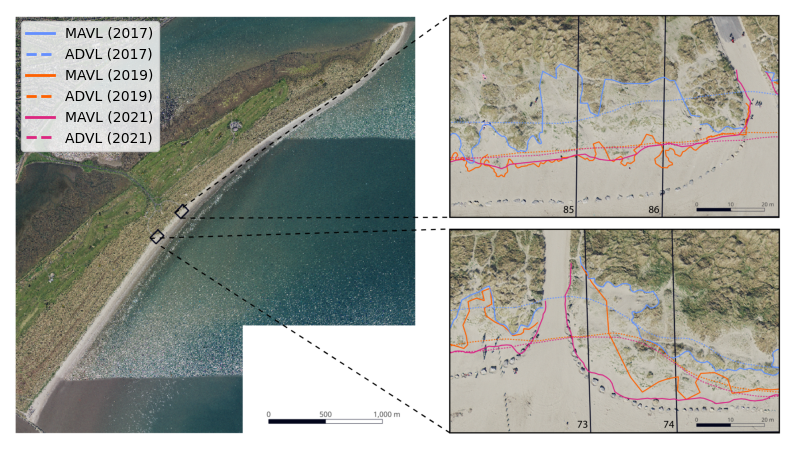

In [74]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

crop_path = figure_path+ "/rough/bull_island_outlier.png"
img1 = PIL.Image.open(crop_path)
ax.imshow(img1)


# create custom legend
handles = [
    plt.Line2D([0], [0], color=blue, lw=2, label='MAVL (2017)'),
    plt.Line2D([0], [0], color=blue, lw=2, linestyle='--', label='ADVL (2017)'),
    plt.Line2D([0], [0], color=orange, lw=2, label='MAVL (2019)'),
    plt.Line2D([0], [0], color=orange, lw=2, linestyle='--', label='ADVL (2019)'),
    plt.Line2D([0], [0], color=red, lw=2, label='MAVL (2021)'),
    plt.Line2D([0], [0], color=red, lw=2, linestyle='--', label='ADVL (2021)')

]
ax.legend(handles=handles, loc='upper left', fontsize=10, bbox_to_anchor=(0.005, 0.99))

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

save_path = os.path.join(figure_path, "bull_island_outlier.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

### Figure: Erosion Rates Bull Island

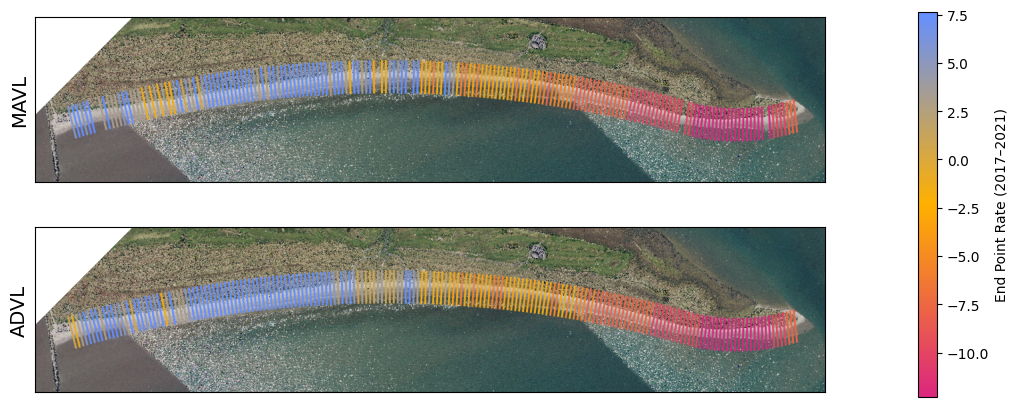

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,5))

#MAVL
crop_path = figure_path+ "/rough/MAVL.png"
img1 = PIL.Image.open(crop_path)

ax[0].imshow(img1)
ax[0].set_ylabel("MAVL", fontsize=14)

#ADVL
crop_path = figure_path+ "/rough/ADVL.png"
img2 = PIL.Image.open(crop_path)

ax[1].imshow(img2)
ax[1].set_ylabel("ADVL", fontsize=14)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# --- Define custom colormap ---
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", ["#dc267f", "#ffb000", "#648fff"]
)

# --- Create a normalizer (adjust min/max to match your QGIS values) ---
norm = mpl.colors.Normalize(vmin=-12.3, vmax=7.63)  # adjust as needed

# --- Add colorbar ---
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    fraction=0.05,
    pad=0.1,
)
cbar.set_label("End Point Rate (2017–2021)")

save_path = os.path.join(figure_path, "erosion_rates_rotate.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)